### Imports and Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import io
import requests
import os

from scipy.stats import zscore
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from IPython.display import display

from imblearn.over_sampling import SMOTE

Panda Preferences

In [2]:
# Set options for displaying maximum columns and rows
pd.set_option('display.max_columns', None)  
#pd.set_option('display.max_rows', None)

**Read CSV**

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv("../../../Datasets/Flows/iomt_flows.csv")

# Display the DataFrame
display(df)

/project/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,traffic,label
0,10.10.10.252,33540,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,73,0,0,-,0.0,1,0,1,0,0.0,0.0,0.0,0.0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,45.0,45.0,45.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,45.0,45.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
1,10.10.10.252,50435,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,74,0,0,-,0.0,1,0,1,0,0.0,0.0,0.0,0.0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,46.0,46.0,46.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,46.0,46.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
2,10.10.10.252,47976,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,57,0,0,-,0.0,1,0,1,0,0.0,0.0,0.0,0.0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,29.0,29.0,29.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,29.0,29.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
3,10.10.10.252,37995,10.10.10.0,137,udp,dns,-,-,-,S0,T,T,0,D,1,78,0,0,-,0.0,1,0,1,0,0.0,0.0,0.0,0.0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0,50.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,50.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
4,10.10.10.252,38680,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,67,0,0,-,0.0,1,0,1,0,0.0,0.0,0.0,0.0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,39.0,39.0,39.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,39.0,39.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4325373,42.32.107.34,32572,148.94.193.65,52545,tcp,-,-,-,-,OTH,F,F,0,-,0,0,0,0,-,0.0,1,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Fix Dataframe Mixed Types

In [4]:
# Remove rows with '-' character in columns 6, 7 and 8
cols_to_check = ['duration', 'orig_bytes', 'resp_bytes']

# Create a boolean mask to identify rows with '-' character
mask = df[cols_to_check].apply(lambda x: x.str.contains('-', na=False)).any(axis=1)

# Use the mask to filter out rows with '-' character
df = df[~mask]

# Replace comma with period as decimal separator
cols_to_float = ['duration']

# Replace ',' with '.' in specified columns
df[cols_to_float] = df[cols_to_float].replace(',', '.', regex=True)

# Convert columns 7 and 8 to float and int data types
cols_to_int = ['orig_bytes', 'resp_bytes']

# Convert specified columns to float and int types
df[cols_to_float] = df[cols_to_float].astype(float)
df[cols_to_int] = df[cols_to_int].astype(int)

-----------------------------------------------------------

## DF Statistics and Info

In [5]:
def display_information_dataframe(df_cop):
    # Create a summary of data types, column names, and unique values
    summary_data = [{'Data Type': dtype, 'Column Name': col, 'Unique Values': df_cop[col].unique()} for col, dtype in df_cop.dtypes.iteritems()]
    
    # Create a DataFrame from the summary data
    summary_df = pd.DataFrame(summary_data)
    
    # Set display options to show all rows and columns
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    
    # Return the summary DataFrame
    return summary_df

In [6]:
display_information_dataframe(df)

,Data Type,Column Name,Unique Values
0,object,id.orig_h,"[10.10.10.252, 10.10.10.1, 10.10.10.249, 0.0.0..."
1,int64,id.orig_p,"[5353, 36990, 45852, 55492, 59436, 60249, 5084..."
2,object,id.resp_h,"[224.0.0.251, 10.10.10.255, 10.10.10.249, 255...."
3,int64,id.resp_p,"[5353, 57621, 80, 22, 48969, 54845, 19582, 355..."
4,object,proto,"[udp, tcp, icmp]"
5,object,service,"[dns, -, http, mqtt, dhcp]"
6,float64,duration,"[57.262413, 3.002431, 0.208294, 0.209607, 0.20..."
7,int64,orig_bytes,"[1515, 75, 406, 405, 586, 569, 759, 763, 583, ..."
8,int64,resp_bytes,"[0, 851, 712, 310, 1111456671, 1287165066, 173..."
9,object,conn_state,"[S0, SH, RSTR, OTH, RSTRH, S2, RSTOS0, REJ, SH..."


--------------------------------------------

## Pre-processing and Data Encoding

Split History

In [7]:
def count_letters(string, is_upper):
    count = 0
    
    # Iterate through each character in the string
    for c in string:
        if is_upper and c.isupper():  # Check if the character is uppercase
            count += 1
        elif not is_upper and c.islower():  # Check if the character is lowercase
            count += 1
    
    return count

In [8]:
print('[SPLIT HISTORY] history_originator')
df['history_originator'] = df['history'].apply(lambda x: count_letters(x, True))

print('[SPLIT HISTORY] history_responder')
df['history_responder'] = df['history'].apply(lambda x: count_letters(x, False))

[SPLIT HISTORY] history_originator
[SPLIT HISTORY] history_responder


Decimal Scale Normalization

In [9]:
# Multiply by 1000 for a bigger scale
print('[DECIMAL SCALE NORMALIZATION] flow_duration')
df['flow_duration'] *= 1000

# Multiply by 100 for a bigger scale
print('[DECIMAL SCALE NORMALIZATION] duration')
df['duration'] *= 100

# Multiply by 10 for a bigger scale
print('[DECIMAL SCALE NORMALIZATION] down_up_ratio')
df['down_up_ratio'] *= 10

[DECIMAL SCALE NORMALIZATION] flow_duration
[DECIMAL SCALE NORMALIZATION] duration
[DECIMAL SCALE NORMALIZATION] down_up_ratio


Data Normalization

In [10]:
# Update values in 'bwd_PSH_flag_count' column if they are higher than 4
print('[DATA NORMALIZATION] bwd_PSH_flag_count')
df.loc[df['bwd_PSH_flag_count'] > 4, 'bwd_PSH_flag_count'] = 5

# Update values in 'bwd_data_pkts_tot' column if they are higher than 3
print('[DATA NORMALIZATION] bwd_data_pkts_tot')
df.loc[df['bwd_data_pkts_tot'] > 3, 'bwd_data_pkts_tot'] = 5

[DATA NORMALIZATION] bwd_PSH_flag_count
[DATA NORMALIZATION] bwd_data_pkts_tot


Remove Outliers

In [11]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print(f'[REMOVED OUTLIERS] {col}')
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [12]:
outliers = [
    'resp_ip_bytes',
    'orig_pkts',
    'flow_duration',
    'duration',
    'bwd_pkts_tot',
    'bwd_pkts_payload.avg',
    'bwd_header_size_tot',
    'resp_pkts',
]

df = remove_outliers(df, outliers, 3)

[REMOVED OUTLIERS] resp_ip_bytes
[REMOVED OUTLIERS] orig_pkts
[REMOVED OUTLIERS] flow_duration
[REMOVED OUTLIERS] duration
[REMOVED OUTLIERS] bwd_pkts_tot
[REMOVED OUTLIERS] bwd_pkts_payload.avg
[REMOVED OUTLIERS] bwd_header_size_tot
[REMOVED OUTLIERS] resp_pkts


One Hot Encoding

In [13]:
def one_hot_encoding(df, columns):
    for col in columns:
        print(f'[ONE HOT ENCODING] {col}')
        df = pd.get_dummies(df, columns=[col], prefix=col)  # Perform one-hot encoding on the column
    
    return df

In [14]:
cols_to_encode = [
    'proto',
    'local_resp',
    'local_orig',
    'fwd_header_size_min',
    'fwd_header_size_max',
    'flow_SYN_flag_count',
    'flow_RST_flag_count',
    'flow_FIN_flag_count',
    'conn_state',
    'bwd_PSH_flag_count',
    'bwd_header_size_min',
    'bwd_header_size_max',
    'resp_pkts',
]

df = one_hot_encoding(df,cols_to_encode)

[ONE HOT ENCODING] proto
[ONE HOT ENCODING] local_resp
[ONE HOT ENCODING] local_orig
[ONE HOT ENCODING] fwd_header_size_min
[ONE HOT ENCODING] fwd_header_size_max
[ONE HOT ENCODING] flow_SYN_flag_count
[ONE HOT ENCODING] flow_RST_flag_count
[ONE HOT ENCODING] flow_FIN_flag_count
[ONE HOT ENCODING] conn_state
[ONE HOT ENCODING] bwd_PSH_flag_count
[ONE HOT ENCODING] bwd_header_size_min
[ONE HOT ENCODING] bwd_header_size_max
[ONE HOT ENCODING] resp_pkts


Normalize, Z-score

In [15]:
def zscore_normalization(df, cols):
    # Standardize the selected columns
    for col in cols:
        if col not in df.columns:
            print(f"[WARNING] {col} not found in DataFrame.")
            continue
        print(f"[Z-SCORE] {col}")
        df[col] = zscore(df[col])
    
    print("[DONE] Z-score Normalization")
    print("[INFO] Current Fields in the DataFrame:")
    return df

In [16]:
cols_to_zscore = [
    'resp_ip_bytes',
    'resp_bytes',
    'payload_bytes_per_second',
    'orig_pkts',
    'orig_ip_bytes',
    'orig_bytes',
    'fwd_subflow_pkts',
    'fwd_subflow_bytes',
    'fwd_PSH_flag_count',
    'fwd_pkts_tot',
    'fwd_pkts_per_sec',
    'fwd_pkts_payload.tot',
    'fwd_pkts_payload.std',
    'fwd_pkts_payload.min',
    'fwd_pkts_payload.max',
    'fwd_pkts_payload.avg',
    'fwd_last_window_size',
    'fwd_init_window_size',
    'fwd_iat.tot',
    'fwd_iat.std',
    'fwd_iat.min',
    'fwd_iat.max', 
    'fwd_iat.avg',
    'fwd_header_size_tot',
    'fwd_data_pkts_tot',
    'fwd_bulk_bytes',
    'flow_pkts_per_sec',
    'flow_pkts_payload.tot',
    'flow_pkts_payload.std',
    'flow_pkts_payload.min',
    'flow_pkts_payload.max',
    'flow_pkts_payload.avg',
    'flow_iat.tot',
    'flow_iat.std',
    'flow_iat.min',
    'flow_iat.max',
    'flow_iat.avg',
    'flow_duration',
    'flow_ACK_flag_count',
    'duration',
    'down_up_ratio',
    'bwd_subflow_pkts',
    'bwd_subflow_bytes',
    'bwd_pkts_tot',
    'bwd_pkts_per_sec',
    'bwd_pkts_payload.tot',
    'bwd_pkts_payload.std',
    'bwd_pkts_payload.max',
    'bwd_pkts_payload.avg',
    'bwd_last_window_size',
    'bwd_init_window_size',
    'bwd_iat.tot',
    'bwd_iat.min',
    'bwd_iat.max',
    'bwd_iat.avg',
    'bwd_header_size_tot',
    'active.tot',
    'active.min',
    'active.max',
    'active.avg',    
]

df = zscore_normalization(df, cols_to_zscore)

[Z-SCORE] resp_ip_bytes
[Z-SCORE] resp_bytes
[Z-SCORE] payload_bytes_per_second
[Z-SCORE] orig_pkts
[Z-SCORE] orig_ip_bytes
[Z-SCORE] orig_bytes
[Z-SCORE] fwd_subflow_pkts
[Z-SCORE] fwd_subflow_bytes
[Z-SCORE] fwd_PSH_flag_count
[Z-SCORE] fwd_pkts_tot
[Z-SCORE] fwd_pkts_per_sec
[Z-SCORE] fwd_pkts_payload.tot
[Z-SCORE] fwd_pkts_payload.std
[Z-SCORE] fwd_pkts_payload.min
[Z-SCORE] fwd_pkts_payload.max
[Z-SCORE] fwd_pkts_payload.avg
[Z-SCORE] fwd_last_window_size
[Z-SCORE] fwd_init_window_size
[Z-SCORE] fwd_iat.tot


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


[Z-SCORE] fwd_iat.std
[Z-SCORE] fwd_iat.min
[Z-SCORE] fwd_iat.max
[Z-SCORE] fwd_iat.avg
[Z-SCORE] fwd_header_size_tot
[Z-SCORE] fwd_data_pkts_tot
[Z-SCORE] fwd_bulk_bytes
[Z-SCORE] flow_pkts_per_sec
[Z-SCORE] flow_pkts_payload.tot
[Z-SCORE] flow_pkts_payload.std
[Z-SCORE] flow_pkts_payload.min
[Z-SCORE] flow_pkts_payload.max
[Z-SCORE] flow_pkts_payload.avg
[Z-SCORE] flow_iat.tot
[Z-SCORE] flow_iat.std
[Z-SCORE] flow_iat.min
[Z-SCORE] flow_iat.max
[Z-SCORE] flow_iat.avg
[Z-SCORE] flow_duration
[Z-SCORE] flow_ACK_flag_count
[Z-SCORE] duration
[Z-SCORE] down_up_ratio
[Z-SCORE] bwd_subflow_pkts
[Z-SCORE] bwd_subflow_bytes
[Z-SCORE] bwd_pkts_tot
[Z-SCORE] bwd_pkts_per_sec
[Z-SCORE] bwd_pkts_payload.tot
[Z-SCORE] bwd_pkts_payload.std
[Z-SCORE] bwd_pkts_payload.max
[Z-SCORE] bwd_pkts_payload.avg
[Z-SCORE] bwd_last_window_size
[Z-SCORE] bwd_init_window_size
[Z-SCORE] bwd_iat.tot
[Z-SCORE] bwd_iat.min
[Z-SCORE] bwd_iat.max
[Z-SCORE] bwd_iat.avg
[Z-SCORE] bwd_header_size_tot
[Z-SCORE] active.tot

Delete Insignificant Columns from the Dataframe

In [17]:
def delete_columns(df, cols):
    for col in cols:
        df.drop(col, axis = 1, inplace = True)
        print(f'[REMOVED] {col}')
    
    return df

In [18]:
cols_to_del = [
    'tunnel_parents',
    'service',
    'missed_bytes',
    'idle.tot',
    'idle.std',
    'idle.min',
    'idle.max',
    'idle.avg',
    'fwd_URG_flag_count',
    'fwd_bulk_rate',
    'fwd_bulk_packets',
    'flow_ECE_flag_count',
    'flow_CWR_flag_count',
    'bwd_URG_flag_count',
    'bwd_pkts_payload.min',
    'bwd_iat.std',
    'bwd_bulk_rate',
    'bwd_bulk_packets',
    'bwd_bulk_bytes',
    'active.std',
    'id.orig_h',
    'id.orig_p',
    'id.resp_h',
    'id.resp_p',
    'history',
]

df = delete_columns(df,cols_to_del)

[REMOVED] tunnel_parents
[REMOVED] service
[REMOVED] missed_bytes
[REMOVED] idle.tot
[REMOVED] idle.std
[REMOVED] idle.min
[REMOVED] idle.max
[REMOVED] idle.avg
[REMOVED] fwd_URG_flag_count
[REMOVED] fwd_bulk_rate
[REMOVED] fwd_bulk_packets
[REMOVED] flow_ECE_flag_count
[REMOVED] flow_CWR_flag_count
[REMOVED] bwd_URG_flag_count
[REMOVED] bwd_pkts_payload.min
[REMOVED] bwd_iat.std
[REMOVED] bwd_bulk_rate
[REMOVED] bwd_bulk_packets
[REMOVED] bwd_bulk_bytes
[REMOVED] active.std
[REMOVED] id.orig_h
[REMOVED] id.orig_p
[REMOVED] id.resp_h
[REMOVED] id.resp_p
[REMOVED] history


---------------------------------------

## Create Model & Train Model

In [19]:
df['label'] = df['traffic'].apply(lambda x: 0 if x == "normal" else 1)
df.groupby('label')['label'].count()

label
0          3
1    1597187
Name: label, dtype: int64

In [20]:
df = delete_columns(df,['traffic'])

[REMOVED] traffic


In [21]:
x_columns = df.columns.drop('label')

le = LabelEncoder()
le.fit(df["label"].values)

x = df[x_columns].values
y = df["label"].values
y = le.transform(y)

In [22]:
# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

In [23]:
# Split into training and testing sets
x_train_train, x_test_train, y_train_train, y_test_train = train_test_split(x_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [24]:
x_test.shape,y_test.shape

((399298, 105), (399298,))

In [25]:
x_train.shape,y_train.shape

((1197892, 105), (1197892,))

In [26]:
# Define the model
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Define early stopping
monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.5,mode="min",patience=10,verbose=1,min_lr=1e-7)
checkpoint = ModelCheckpoint('best_model_binary.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=512, callbacks=[monitor, checkpoint])

Train on 1197892 samples, validate on 399298 samples
Epoch 1/100
1197892/1197892 [==============================] - 6s 5us/sample - loss: 0.0336 - accuracy: 0.9996 - val_loss: 2.3100e-04 - val_accuracy: 1.0000
Epoch 2/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 2.9092e-04 - accuracy: 1.0000 - val_loss: 4.7007e-05 - val_accuracy: 1.0000
Epoch 3/100
1197892/1197892 [==============================] - 5s 5us/sample - loss: 7.9712e-05 - accuracy: 1.0000 - val_loss: 3.4816e-05 - val_accuracy: 1.0000
Epoch 4/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.9281e-05 - accuracy: 1.0000 - val_loss: 3.7018e-05 - val_accuracy: 1.0000
Epoch 5/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 4.0823e-05 - accuracy: 1.0000 - val_loss: 4.0239e-05 - val_accuracy: 1.0000
Epoch 6/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.3285e-05 - accuracy: 1.0000 - val_loss: 4.2908e-05 - val_ac

Epoch 47/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.3472e-05 - accuracy: 1.0000 - val_loss: 5.0905e-05 - val_accuracy: 1.0000
Epoch 48/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 2.7749e-05 - accuracy: 1.0000 - val_loss: 5.0867e-05 - val_accuracy: 1.0000
Epoch 49/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 4.2087e-05 - accuracy: 1.0000 - val_loss: 5.0793e-05 - val_accuracy: 1.0000
Epoch 50/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 4.0371e-05 - accuracy: 1.0000 - val_loss: 5.0638e-05 - val_accuracy: 1.0000
Epoch 51/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.5893e-05 - accuracy: 1.0000 - val_loss: 5.0508e-05 - val_accuracy: 1.0000
Epoch 52/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.2877e-05 - accuracy: 1.0000 - val_loss: 5.0437e-05 - val_accuracy: 1.0000
Epoch 53/100
1191936/1197892

1188864/1197892 [============================>.] - ETA: 0s - loss: 3.8218e-05 - accuracy: 1.0000
Epoch 00093: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.7936e-05 - accuracy: 1.0000 - val_loss: 5.0264e-05 - val_accuracy: 1.0000
Epoch 94/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 4.4558e-05 - accuracy: 1.0000 - val_loss: 5.0256e-05 - val_accuracy: 1.0000
Epoch 95/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.7995e-05 - accuracy: 1.0000 - val_loss: 5.0251e-05 - val_accuracy: 1.0000
Epoch 96/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.1917e-05 - accuracy: 1.0000 - val_loss: 5.0249e-05 - val_accuracy: 1.0000
Epoch 97/100
1197892/1197892 [==============================] - 5s 4us/sample - loss: 3.0460e-05 - accuracy: 1.0000 - val_loss: 5.0245e-05 - val_accuracy: 1.0000
Epoch 98/100
1197892/1197

In [28]:
# Load the best saved model
best_model = load_model('best_model_binary.h5')

# Evaluate the best saved model
score = best_model.evaluate(x_test, y_test)
print('')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

399298/399298 [==============================] - 9s 21us/sample - loss: 3.4816e-05 - accuracy: 1.0000

Test loss: 3.481584254011746e-05
Test accuracy: 0.9999975


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               27136     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

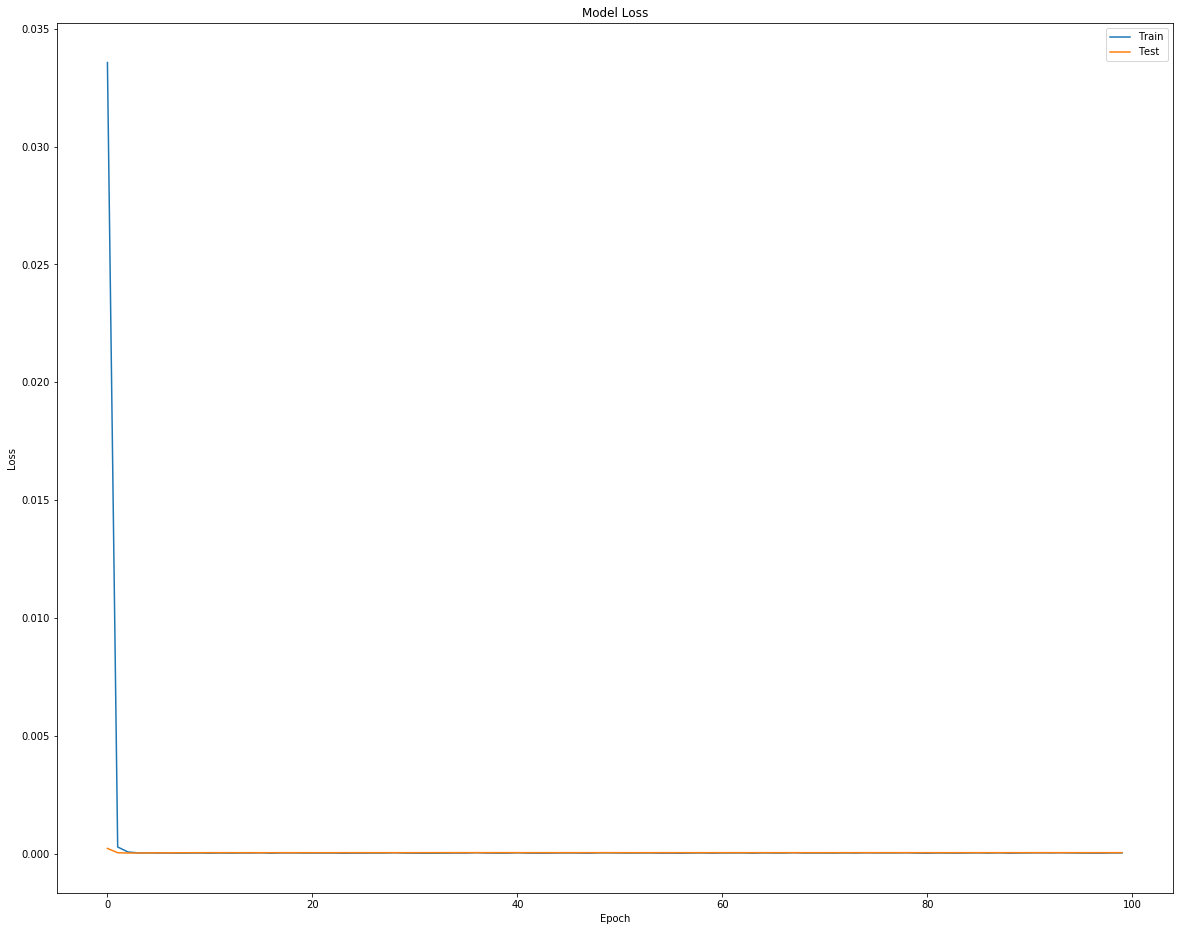

In [30]:
fig, ax = plt.subplots(figsize=(20, 16))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [31]:
pred = model.predict(x_test)

In [32]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


def calculate_metrics(modelName, yTrue, yPred, average='binary'):
    """
    Calculate and print the performance metrics of a classification model.
    
    Parameters:
    modelName (str): The name of the classification model.
    yTrue (array-like): The true labels.
    yPred (array-like): The predicted labels.
    average (str or None, optional): The averaging method to use for multi-class classification. One of 
        {'micro', 'macro', 'weighted', 'binary'} or None (default: 'binary'). If None, only binary 
        classification metrics will be computed.
    
    Raises:
    ValueError: If `average` is not one of {'micro', 'macro', 'weighted', 'binary'} or None.
    
    """    
    # Check if average parameter is valid
    if average != 'micro' and average != 'macro' and average != 'weighted' and average != 'binary' and average != None:
        print("Average must be one of this options: {‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} or None, default=’binary’")
        return
    
    # Prints the name of the model and calculate accuracy and precision
    print(f"--- Performance of {modelName} ---")
    acc = accuracy_score(y_true = yTrue, y_pred = yPred)
    precision = precision_score(y_true = yTrue, y_pred = yPred, average = average)
    print(f'Accuracy : {np.round(acc*100,2)}%\nPrecision: {np.round(precision*100,2)}%')
    
    # Calculates and print recall and F1-score
    f1 = f1_score(y_true = yTrue, y_pred = yPred, average = average)
    recall = recall_score(y_true = yTrue, y_pred = yPred, average = average)
    print(f'Recall: {np.round(recall*100,2)}%\nF1-score: {np.round(f1*100,2)}%')
    
    #auc_sklearn = roc_auc_score(y_true = yTrue, y_score = yPred, average = average)
    #print(f'Roc auc: {np.round(auc_sklearn*100,2)}%')
    
    # Calculates and prints balanced accuracy and classification report
    print(f"Balanced accuracy: {np.round(balanced_accuracy_score(yTrue, yPred)*100,2)}%")
    print(f"Classification report:\n{classification_report(yTrue, yPred)}")

In [33]:
pred = np.round(pred).astype(int)
calculate_metrics("Binary - DNN", y_test, pred)

--- Performance of Binary - DNN ---
Accuracy : 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%
Balanced accuracy: 50.0%
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00    399297

    accuracy                           1.00    399298
   macro avg       0.50      0.50      0.50    399298
weighted avg       1.00      1.00      1.00    399298



/project/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------

**Result Plots**

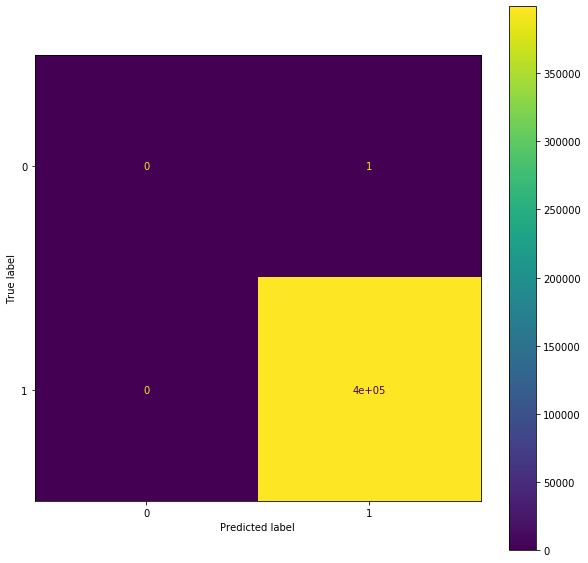

In [34]:
# Compute confusion matrix
y_pred = np.round(pred).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax)

In [35]:
# Usage of ExtraTreesClassifier for feature selection
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)
extra_tree_forest.fit(x, y)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# Plor for the ExtraTreesClassifier output
plot.bar(x_columns, feature_importance_normalized)
plot.xlabel('Feature Labels')
plot.ylabel('Feature Importances')
plot.title('Comparison of different feature importances in the current dataset')
plot.xticks(rotation = 90)

# Plot size
plot.rcParams["figure.figsize"] = (70, 40)

plot.show()

## 